In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


In [ ]:
qty_df = pd.read_csv('/content/Production Quantity.csv')
ppt_df = pd.read_csv('/content/Daily Precipitation.csv')
sm_df = pd.read_csv('/content/Daily Soil Mositure.csv')
temp_df = pd.read_csv('/content/Daily Temperature.csv')
ndvi_df = pd.read_csv('/content/Eight Day NDVI.csv')

In [ ]:
## Precipitation

In [ ]:
ppt_df.info()

In [ ]:
def create_date_month(df):
  df['start_date'] = pd.to_datetime(df['start_date'])
  df['start'] = df['start_date'].dt.date
  df['month_year'] = df['start_date'].dt.strftime('%m-%Y')
  return df

In [ ]:
ppt_df = create_date_month(ppt_df)

In [ ]:
ppt_df['start_date'] = pd.to_datetime(ppt_df['start_date'])
ppt_df['start'] = ppt_df['start_date'].dt.date

In [ ]:
ppt_df

In [ ]:
#calculate sum of precipitation grouped by month
precipitation_df = ppt_df.groupby(['month_year','region_id'])['precip'].sum()
precipitation_df = precipitation_df.reset_index()

In [ ]:
qty_df = create_date_month(qty_df)

In [ ]:
## Soil moisture

In [ ]:
sm_df = create_date_month(sm_df)

In [ ]:
#calculate avg of moisture grouped by month
moisture_df = sm_df.groupby(['month_year','region_id'])['smos'].mean()
moisture_df = moisture_df.reset_index()


In [ ]:
Data_df = pd.merge(precipitation_df,moisture_df,on=['month_year','region_id'])

In [ ]:
## Temperature

In [ ]:
temp_df = create_date_month(temp_df)

In [ ]:
#calculate avg of temp grouped by month
mean_temperature_df = temp_df.groupby(['month_year','region_id'])['temp'].mean()
mean_temperature_df = mean_temperature_df.reset_index()

In [ ]:
## Creating a feature called max temperature
temp_df['max_temp']= temp_df.groupby(['month_year','region_id'])['temp'].transform(max)

In [ ]:
max_temp_df = temp_df[['region_id','month_year','max_temp']]
max_temp_df = max_temp_df.drop_duplicates()

In [ ]:
temperature_df = pd.merge(mean_temperature_df,max_temp_df,on=['month_year','region_id'])

In [ ]:
temperature_df

,month_year,region_id,temp,max_temp
0,01-2014,93,25.482158,30.196658
1,01-2014,94,25.857623,29.822020
2,01-2014,95,22.430714,26.503133
3,01-2014,97,25.554444,28.656484
4,01-2014,98,23.789993,26.682990
...,...,...,...,...
985,12-2021,99,25.431461,28.611530
986,12-2021,102,24.178574,26.361874
987,12-2021,103,24.978023,26.087139
988,12-2021,104,27.759955,30.140744


In [ ]:
Data_df = pd.merge(Data_df,temperature_df,on=['month_year','region_id'])

In [ ]:
## NDVI

In [ ]:
ndvi_df = create_date_month(ndvi_df)

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,8

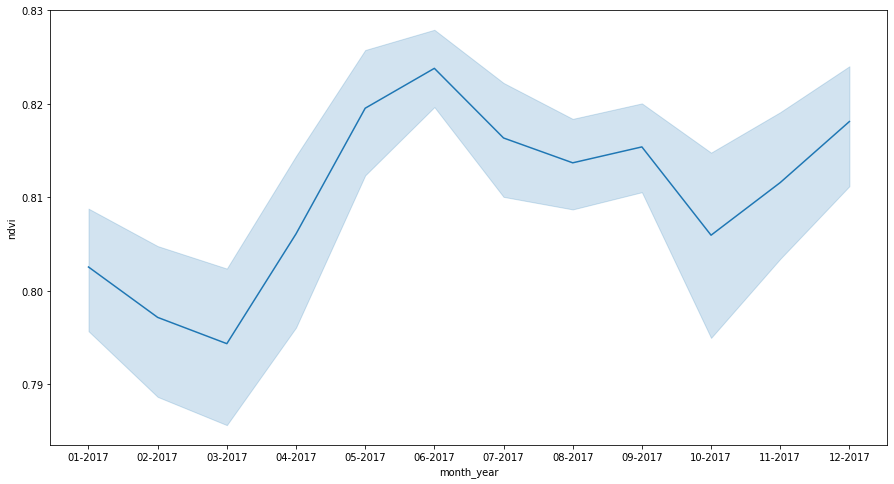

In [ ]:
reg_2014 = ndvi_df[(ndvi_df['month_year'].str[-4:] == '2017') ]
sns.lineplot(data=reg_2014, x="month_year", y="ndvi")

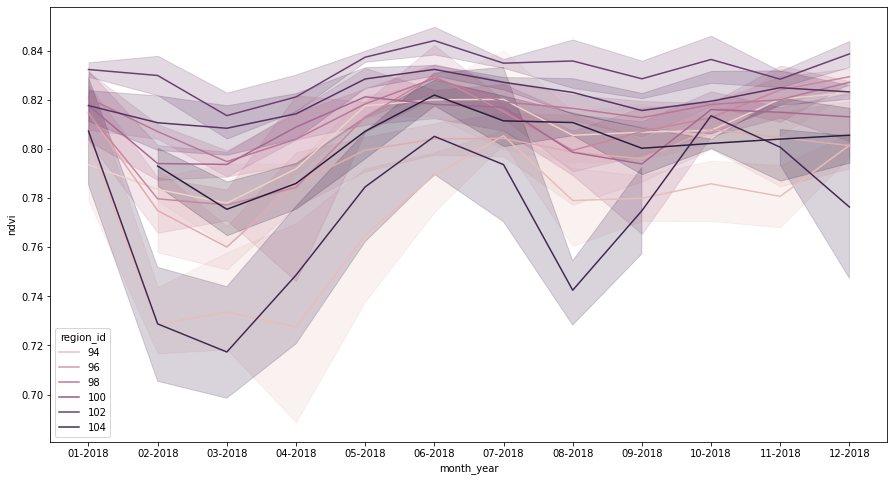

In [ ]:
#reg_93 = ndvi_df[(ndvi_df['region_id']==93) & (ndvi_df['month_year'].str[-4:] == '2015') ]
reg_93 = ndvi_df[(ndvi_df['month_year'].str[-4:] == '2018') ]
sns.lineplot(data=reg_93, x="month_year", y="ndvi",hue = 'region_id')

## From the above plots we can see that crop growth is maximum around June just before harvesting when the harvesting period begins.
## We will create a feature called maximum_ndvi which should represent the final amount  of crop for that region before harvesting 

In [ ]:
#calculate avg of NDVI grouped by month
NDVI_df = ndvi_df.groupby(['month_year','region_id'])['ndvi'].mean()
NDVI_df = NDVI_df.reset_index()

In [ ]:
NDVI_df

In [ ]:
ndvi_df['max_ndvi']= ndvi_df.groupby(['month_year','region_id'])['ndvi'].transform(max)

In [ ]:
max_ndvi_df = ndvi_df[['region_id','month_year','max_ndvi']]
max_ndvi_df = max_ndvi_df.drop_duplicates()

In [ ]:
NDVI_df = pd.merge(NDVI_df,max_ndvi_df,on=['month_year','region_id'])

In [ ]:
## Merge with Data_df
Data_df = pd.merge(Data_df,NDVI_df,on=['month_year','region_id'],how='left')

In [ ]:
Data_df

In [ ]:
Data_df[Data_df['ndvi'].isna()]

In [ ]:
## dropping years 2014 and 2022 rows from Data_df
Train_test_data = Data_df[(Data_df['month_year'].str[-4:] != '2014') & (Data_df['month_year'].str[-4:] != '2022') ]


In [ ]:
value = Train_test_data[Train_test_data['month_year']=='11-2016']['ndvi'].mean()
Train_test_data['ndvi'].fillna(value= value,inplace=True)

In [ ]:
value2 = Train_test_data[Train_test_data['month_year']=='11-2016']['ndvi'].max()
Train_test_data['max_ndvi'].fillna(value= value2,inplace=True)

In [ ]:
Train_test_data.info()

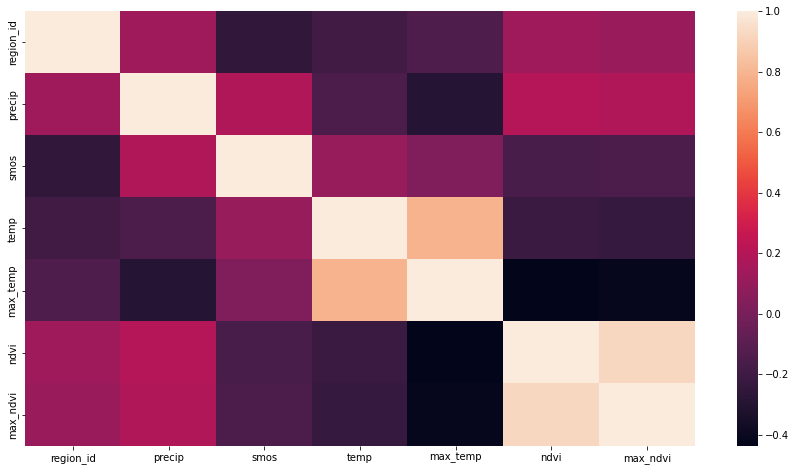

In [ ]:
sns.heatmap(Train_test_data.corr())

In [ ]:
## Split Train and Test data
train_feat = Train_test_data[(Train_test_data['month_year'].str[-4:] != '2021')]
train_data = pd.merge(train_feat,qty_df,on=['month_year','region_id'])
test_data = Train_test_data[(Train_test_data['month_year'].str[-4:] == '2021')]

In [ ]:
train_data = train_data.drop(['start_date','end_date','start','month_year'],axis = 1)

In [ ]:
test_data = test_data.drop(['month_year'],axis=1)

In [ ]:
## encoding region_id as it is a categorical variable
from sklearn.preprocessing import OneHotEncoder
def one_hot_encode(df):
  new_df = pd.get_dummies(df, columns=['region_id'])
  return new_df

train_data = one_hot_encode(train_data)
X_test = one_hot_encode(test_data)


In [ ]:
y = train_data['prod']
y=pd.DataFrame(y)
train_data = train_data.drop(['prod'],axis=1)

In [ ]:
train_data.describe()

In [ ]:
## standardize train and validation data since there are high standard deviation

In [ ]:
scaler = RobustScaler(copy = True)
train1_data = scaler.fit_transform(train_data)
train_data = pd.DataFrame(train1_data,columns = train_data.columns)

In [ ]:
scaler = RobustScaler(copy = True)
test1_data = scaler.fit_transform(X_test)
X_test = pd.DataFrame(test1_data,columns = X_test.columns)

In [ ]:
train_data.hist(figsize=(25, 20))

In [ ]:
y = np.log(y)
y.hist(figsize=(5, 5))

In [ ]:
train_data.describe()

,precip,smos,temp,max_temp,ndvi,max_ndvi,region_id_93,region_id_94,region_id_95,region_id_97,region_id_98,region_id_99,region_id_102,region_id_103,region_id_104,region_id_105
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.071250,-0.027610,-0.008144,0.034075,-0.204419,-0.177103,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
std,0.748169,0.702630,0.685694,0.841397,0.926064,0.900814,0.300209,0.300209,0.300209,0.300209,0.300209,0.300209,0.300209,0.300209,0.300209,0.300209
min,-1.380002,-1.992248,-1.714041,-2.737684,-6.050187,-5.674348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.486057,-0.534103,-0.515275,-0.504616,-0.586570,-0.582569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.513943,0.465897,0.484725,0.495384,0.413430,0.417431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.954153,1.720634,2.237516,3.556449,1.314499,1.454388,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
## Train validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data, y, test_size=0.2, random_state=42)

In [ ]:
## Modeling the Data

In [ ]:
## Using a XGBoost Regressor model

In [ ]:
import xgboost as xgb
regressor=xgb.XGBRegressor(eval_metric='mae')
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_grid = {"max_depth":    [4, 6,8],
              "n_estimators": [50,100,200,500],
              "learning_rate": [0.01, 0.05, 0.1,0.12]}

search = GridSearchCV(regressor, param_grid,scoring = 'neg_mean_absolute_percentage_error', cv=5).fit(X_train, y_train)

In [ ]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [ ]:
model1=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='mae')

model1.fit(X_train, y_train)

[01:25:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(eval_metric='mae', max_depth=4)

In [ ]:
predictions_xgb = model1.predict(X_val)

In [ ]:
y_val = np.array(y_val)

In [ ]:
y_val = np.exp(y_val)

In [ ]:
predictions_xgb = np.exp(predictions_xgb)
predictions_xgb = predictions_xgb.reshape(144,1)

In [ ]:
def mape(true, pred):
    abs_error = (np.abs(true - pred)) / true
    sum_abs_error = np.sum(abs_error)
    mape_loss = (sum_abs_error / true.size) * 100
    return mape_loss

In [ ]:
mpe = round(mape(y_val,predictions_xgb),2)

In [ ]:
from sklearn.metrics import r2_score
r2=r2_score(y_val,predictions_xgb)

In [ ]:
## XGBOOST
print("The mape is %.2f" % mpe)
print("The r-squared value is %.2f" % r2)

The mape is 15.81
The r-squared value is 0.95


In [ ]:
## Using a Gradient Boosting Regressor Model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
GBR = GradientBoostingRegressor()

In [ ]:
parameters = {'learning_rate': [0.01,0.02,0.04,0.05],
                  'n_estimators' : [100,200,500,800],
                  'max_depth'    : [4,6,8]
                 }

In [ ]:
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 5, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.04, 0.05],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300, 500, 800, 1000]})

In [ ]:
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)


 The best parameters across ALL searched params:
 {'learning_rate': 0.04, 'max_depth': 6, 'n_estimators': 200}


In [ ]:
## GBR
model2 = GradientBoostingRegressor(n_estimators = 200, max_depth= 6,learning_rate= 0.04 )
model2.fit(X_train, y_train)
predictions = model2.predict(X_val)
predictions = np.exp(predictions)
predictions = predictions.reshape(144,1)
mpe = round(mape(y_val,predictions),2)
r2=r2_score(y_val,predictions)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
## GBR
print("The mape is %.2f" % mpe)
print("The r-squared value is %.2f" % r2)

The mape is 15.68
The r-squared value is 0.96


In [ ]:
for i in np.linspace(0,1,21):
    preds = (1-i)*predictions + i*predictions_xgb
    print(mape(y_val,preds))

15.67700839746349
15.628500628835202
15.592368804456857
15.56000752158903
15.533996497066568
15.511923214754155
15.489850344117595
15.46974725750028
15.462906526803003
15.463284421805785
15.464418894849718
15.46810098765635
15.476057161689639
15.486591459997737
15.499705145141274
15.522932148023354
15.56679836327165
15.617505796544437
15.67876496455957
15.740457172898065
15.8093922490371


In [ ]:
## Using a blend of predictions = 0.4*XGBoost and 0.6*Gradient Boosting Regressor since mape is lowest at i=0.4

In [ ]:
test_preds_xgb = model1.predict(X_test)
test_preds_xgb = np.exp(test_preds_xgb)

In [ ]:
test_preds_gbr = model2.predict(X_test)
test_preds_gbr = np.exp(test_preds_gbr)

In [ ]:
test_preds = 0.4*test_preds_xgb + 0.6*test_preds_gbr

In [ ]:
pred_prod_qty_df = pd.read_csv('/content/predicted_production_qty.csv')

In [ ]:
pred_prod_qty_df['prod'] = test_preds

In [ ]:
pred_prod_qty_df.to_csv('angshuman96@utexas.edu.csv', index=False)